In [13]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve
from imblearn.over_sampling import SMOTE

import warnings
warnings.filterwarnings("ignore")


In [14]:
df = pd.read_csv("creditcard.csv")
print("Shape:", df.shape)
df.head()


Shape: (284807, 31)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


Class
0    284315
1       492
Name: count, dtype: int64
Class
0    0.998273
1    0.001727
Name: proportion, dtype: float64


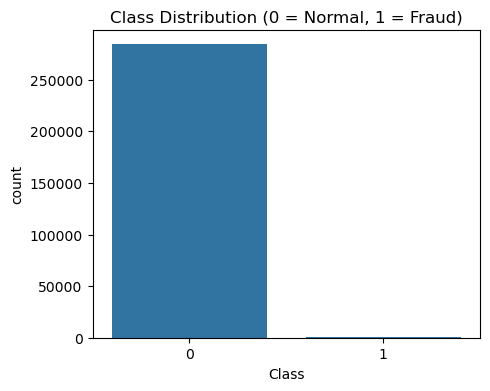

In [15]:
print(df["Class"].value_counts())
print(df["Class"].value_counts(normalize=True))

plt.figure(figsize=(5,4))
sns.countplot(x="Class", data=df)
plt.title("Class Distribution (0 = Normal, 1 = Fraud)")
plt.show()


In [16]:
X = df.drop("Class", axis=1)
y = df["Class"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


In [17]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train_scaled, y_train)

print("Before SMOTE:", y_train.value_counts())
print("After SMOTE:", y_train_res.value_counts())


Before SMOTE: Class
0    227451
1       394
Name: count, dtype: int64
After SMOTE: Class
0    227451
1    227451
Name: count, dtype: int64


In [18]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42)
}

results = {}
for name, model in models.items():
    model.fit(X_train_res, y_train_res)
    y_pred = model.predict(X_test_scaled)
    y_proba = model.predict_proba(X_test_scaled)[:,1]
    
    auc = roc_auc_score(y_test, y_proba)
    results[name] = auc
    
    print(f"\n{name}")
    print("ROC-AUC:", auc)
    print(classification_report(y_test, y_pred, digits=4))



Logistic Regression
ROC-AUC: 0.9708434302252134
              precision    recall  f1-score   support

           0     0.9999    0.9742    0.9869     56864
           1     0.0578    0.9184    0.1088        98

    accuracy                         0.9741     56962
   macro avg     0.5288    0.9463    0.5478     56962
weighted avg     0.9982    0.9741    0.9854     56962


Random Forest
ROC-AUC: 0.9684484390970794
              precision    recall  f1-score   support

           0     0.9997    0.9998    0.9997     56864
           1     0.8710    0.8265    0.8482        98

    accuracy                         0.9995     56962
   macro avg     0.9353    0.9132    0.9240     56962
weighted avg     0.9995    0.9995    0.9995     56962


XGBoost
ROC-AUC: 0.9799832109264639
              precision    recall  f1-score   support

           0     0.9997    0.9995    0.9996     56864
           1     0.7281    0.8469    0.7830        98

    accuracy                         0.9992     56962

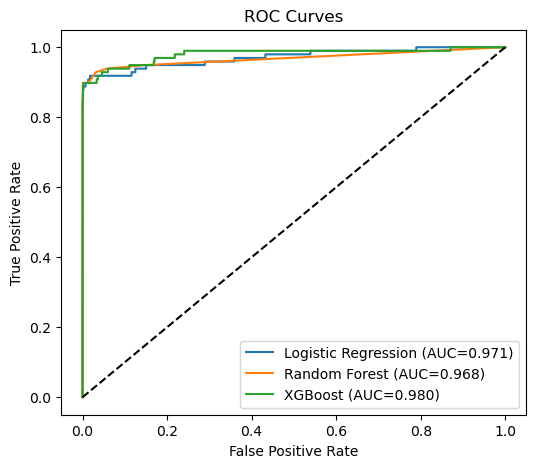

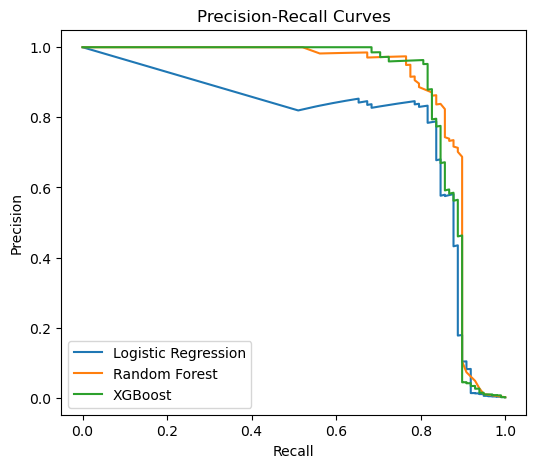

In [19]:
plt.figure(figsize=(6,5))
for name, model in models.items():
    y_proba = model.predict_proba(X_test_scaled)[:,1]
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.plot(fpr, tpr, label=f"{name} (AUC={roc_auc_score(y_test,y_proba):.3f})")

plt.plot([0,1],[0,1],"k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves")
plt.legend()
plt.show()

plt.figure(figsize=(6,5))
for name, model in models.items():
    y_proba = model.predict_proba(X_test_scaled)[:,1]
    precision, recall, _ = precision_recall_curve(y_test, y_proba)
    plt.plot(recall, precision, label=name)

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curves")
plt.legend()
plt.show()
